In [4]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

print("TF Version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

from tqdm import tqdm

FRAMES_PER_CLIP = 10
FRAME_SIZE = (64, 64)   


TF Version: 2.18.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [51]:
FRAMES_PER_CLIP = 10
FRAME_SIZE = (64, 64)   
CACHE_DIR = "/kaggle/working/preprocessed_cache"
os.makedirs(CACHE_DIR, exist_ok=True)

real_life_root = "/kaggle/input/real-life-violence-situations-dataset/Real Life Violence Dataset"
violentflows_root = "/kaggle/input/violent-flows/movies"
ucf_root = "/kaggle/input/ucf-crime-dataset"     
ucf_root_train = "/kaggle/input/ucf-crime-dataset/Train"     
ucf_root_test = "/kaggle/input/ucf-crime-dataset/Test"      
hockey_folder = "/kaggle/input/hockey-fight-vidoes/data"        

LIMIT_REAL_LIFE = 0      
LIMIT_VF_PER_SUBFOLDER = 10
LIMIT_UCF_PER_CLASS = 30
LIMIT_HOCKEY = 0

In [42]:
def read_clip_from_video(path, frames_per_clip=10, size=(64,64)):
    import cv2, numpy as np
    cap = cv2.VideoCapture(path)
    if not cap.isOpened(): 
        return None
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return None
    indices = np.linspace(0, max(total-1,0), frames_per_clip, dtype=int)
    frames = []
    idx = 0
    r_i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx == indices[r_i]:
            try:
                frame = cv2.resize(frame, size)
            except Exception:
                cap.release()
                return None
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame.astype('float32')/255.0)
            r_i += 1
            if r_i >= len(indices):
                break
        idx += 1
    cap.release()
    return np.array(frames) if len(frames)==frames_per_clip else None

def load_hockey_auto(folder, limit=100):
    from tqdm import tqdm
    clips = []; labels = []
    if not folder or not os.path.isdir(folder):
        print("Folder not found:", folder)
        return np.array([]), np.array([])
    files = sorted([f for f in os.listdir(folder) if f.lower().endswith(('.mp4','.avi','.mov'))])
    print("Total video files found:", len(files))
    if limit>0:
        files = files[:limit]
    for f in tqdm(files, desc="Loading hockey"):
        path = os.path.join(folder, f)
        clip = read_clip_from_video(path)
        if clip is not None:
            lname = f.lower()
            label = 1 if (lname.startswith('fi') or 'fight' in lname) else 0
            clips.append(clip); labels.append(label)
    return np.array(clips), np.array(labels)

hk_folder = hockey_folder  
X_hk, y_hk = load_hockey_auto(hk_folder, limit=0)
print("Hockey:", X_hk.shape, y_hk.shape)


Total video files found: 1000


Loading hockey: 100%|██████████| 1000/1000 [00:19<00:00, 51.09it/s]


Hockey: (1000, 10, 64, 64, 3) (1000,)


In [44]:
def read_clip_from_video(path, frames_per_clip=FRAMES_PER_CLIP, size=FRAME_SIZE):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release()
        return None
    indices = np.linspace(0, max(total-1,0), frames_per_clip, dtype=int)
    frames = []
    idx = 0
    read_i = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if idx == indices[read_i]:
            frame = cv2.resize(frame, size)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame.astype(np.float32)/255.0)
            read_i += 1
            if read_i >= len(indices):
                break
        idx += 1
    cap.release()
    if len(frames) == frames_per_clip:
        return np.array(frames, dtype=np.float32)
    return None

def cache_save(name, X, y):
    np.save(os.path.join(CACHE_DIR, f"{name}_X.npy"), X)
    np.save(os.path.join(CACHE_DIR, f"{name}_y.npy"), y)

def cache_load(name):
    xp = os.path.join(CACHE_DIR, f"{name}_X.npy")
    yp = os.path.join(CACHE_DIR, f"{name}_y.npy")
    if os.path.exists(xp) and os.path.exists(yp):
        return np.load(xp), np.load(yp)
    return None, None

In [18]:
def load_real_life(root, limit=LIMIT_REAL_LIFE):
    cache_name = "real_life"
    Xc, yc = cache_load(cache_name)
    if Xc is not None:
        print("Loaded cached Real-Life:", Xc.shape)
        return Xc, yc

    pos_dir = os.path.join(root, "Violence")
    neg_dir = os.path.join(root, "NonViolence")
    clips, labels = [], []
 
    pos_files = sorted(os.listdir(pos_dir)) if os.path.isdir(pos_dir) else []
    if limit>0: pos_files = pos_files[:limit]
    for f in tqdm(pos_files, desc="RealLife Violence"):
        p = os.path.join(pos_dir, f)
        c = read_clip_from_video(p)
        if c is not None:
            clips.append(c); labels.append(1)

    neg_files = sorted(os.listdir(neg_dir)) if os.path.isdir(neg_dir) else []
    if limit>0: neg_files = neg_files[:limit]
    for f in tqdm(neg_files, desc="RealLife NonViolence"):
        p = os.path.join(neg_dir, f)
        c = read_clip_from_video(p)
        if c is not None:
            clips.append(c); labels.append(0)

    X = np.array(clips); y = np.array(labels)
    cache_save(cache_name, X, y)
    return X, y

X_rl, y_rl = load_real_life(real_life_root, limit=LIMIT_REAL_LIFE)
print("Real-Life:", X_rl.shape, y_rl.shape)


RealLife NonViolence:  29%|██▉       | 294/1000 [00:36<07:21,  1.60it/s][h264 @ 0x1418e940] mb_type 104 in P slice too large at 98 31
[h264 @ 0x1418e940] error while decoding MB 98 31
RealLife NonViolence: 100%|██████████| 1000/1000 [01:17<00:00, 12.87it/s]


Real-Life: (2000, 10, 64, 64, 3) (2000,)


In [47]:
def load_violentflows(root, per_sub_limit=LIMIT_VF_PER_SUBFOLDER):
    cache_name = "violentflows"
    Xc, yc = cache_load(cache_name)
    if Xc is not None:
        print("Loaded cached ViolentFlows:", Xc.shape)
        return Xc, yc

    clips, labels = [], []
    if not os.path.isdir(root):
        return np.array([]), np.array([])
    for entry in sorted(os.listdir(root)):
        entry_path = os.path.join(root, entry)
        if not os.path.isdir(entry_path): continue
        # Violence
        vdir = os.path.join(entry_path, "Violence")
        nvdir = os.path.join(entry_path, "NonViolence")
        if os.path.isdir(vdir):
            files = sorted(os.listdir(vdir))[:per_sub_limit] if per_sub_limit>0 else sorted(os.listdir(vdir))
            for f in files:
                c = read_clip_from_video(os.path.join(vdir, f))
                if c is not None:
                    clips.append(c); labels.append(1)
        if os.path.isdir(nvdir):
            files = sorted(os.listdir(nvdir))[:per_sub_limit] if per_sub_limit>0 else sorted(os.listdir(nvdir))
            for f in files:
                c = read_clip_from_video(os.path.join(nvdir, f))
                if c is not None:
                    clips.append(c); labels.append(0)

    X = np.array(clips); y = np.array(labels)
    cache_save(cache_name, X, y)
    return X, y

X_vf, y_vf = load_violentflows(violentflows_root, per_sub_limit=LIMIT_VF_PER_SUBFOLDER)
print("ViolentFlows:", X_vf.shape, y_vf.shape)


Loaded cached ViolentFlows: (99, 10, 64, 64, 3)
ViolentFlows: (99, 10, 64, 64, 3) (99,)


In [52]:
import numpy as np
from tqdm import tqdm
import cv2

def read_clip_from_video(path, frames_per_clip=10, size=(64,64)):
    cap = cv2.VideoCapture(path)
    if not cap.isOpened():
        return None
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total <= 0:
        cap.release(); return None
    indices = np.linspace(0, max(total-1,0), frames_per_clip, dtype=int)
    frames = []; idx = 0; ri = 0
    while True:
        ret, frame = cap.read()
        if not ret: break
        if idx == indices[ri]:
            try:
                f = cv2.resize(frame, size)
            except Exception:
                cap.release(); return None
            f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
            frames.append(f.astype('float32')/255.0)
            ri += 1
            if ri >= len(indices): break
        idx += 1
    cap.release()
    return np.array(frames) if len(frames)==len(indices) else None

def load_ucf_limited_auto(ucf_root, per_class_limit=30, frames_per_clip=10):

    X=[]; y=[]
    if not ucf_root or not os.path.isdir(ucf_root):
        print("UCF root invalid:", ucf_root)
        return np.array([]), np.array([])

    positive_names = ['Fighting','Fights','Fight','fighting','fight']
    negative_names = ['NormalVideos','Normal','NormalVideos','NormalVideo','normalvideos','normal']

    for split in ['Train','Test']:
        split_path = os.path.join(ucf_root, split)
        if not os.path.isdir(split_path):
            continue
        classes = sorted([d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path,d))])
        print(f"\n{split} classes found: {classes}")

        pos_folder = None
        neg_folder = None
        for c in classes:
            if any(p.lower() == c.lower() for p in positive_names) and pos_folder is None:
                pos_folder = c
            if any(n.lower() == c.lower() for n in negative_names) and neg_folder is None:
                neg_folder = c

        if pos_folder is None:
            for c in classes:
                if 'fight' in c.lower():
                    pos_folder = c; break

        if neg_folder is None:
            for c in classes:
                if 'normal' in c.lower() or 'normalvideo' in c.lower():
                    neg_folder = c; break

        print("  mapped positive ->", pos_folder, "negative ->", neg_folder)

        if pos_folder:
            ppath = os.path.join(split_path, pos_folder)
            files = sorted(os.listdir(ppath))
            if per_class_limit>0:
                files = files[:per_class_limit]
            print(f"  Loading {len(files)} from {ppath} as positive")
            for f in tqdm(files):
                clip = read_clip_from_video(os.path.join(ppath,f), frames_per_clip)
                if clip is not None: X.append(clip); y.append(1)

        if neg_folder:
            npath = os.path.join(split_path, neg_folder)
            files = sorted(os.listdir(npath))
            if per_class_limit>0:
                files = files[:per_class_limit]
            print(f"  Loading {len(files)} from {npath} as negative")
            for f in tqdm(files):
                clip = read_clip_from_video(os.path.join(npath,f), frames_per_clip)
                if clip is not None: X.append(clip); y.append(0)

    X = np.array(X); y = np.array(y)
    print("\nLoaded UCF clips:", X.shape, y.shape)
    return X, y

X_ucf, y_ucf = load_ucf_limited_auto(ucf_root, per_class_limit=30, frames_per_clip=10)



Train classes found: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
  mapped positive -> Fighting negative -> NormalVideos
  Loading 30 from /kaggle/input/ucf-crime-dataset/Train/Fighting as positive


100%|██████████| 30/30 [00:00<00:00, 828.88it/s]


  Loading 30 from /kaggle/input/ucf-crime-dataset/Train/NormalVideos as negative


100%|██████████| 30/30 [00:00<00:00, 696.57it/s]



Test classes found: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
  mapped positive -> Fighting negative -> NormalVideos
  Loading 30 from /kaggle/input/ucf-crime-dataset/Test/Fighting as positive


100%|██████████| 30/30 [00:00<00:00, 646.91it/s]


  Loading 30 from /kaggle/input/ucf-crime-dataset/Test/NormalVideos as negative


100%|██████████| 30/30 [00:00<00:00, 742.81it/s]


Loaded UCF clips: (0,) (0,)


In [54]:
parts = []
for arr, lab in [(X_rl,y_rl), (X_vf,y_vf), (X_hk,y_hk)]:
    if isinstance(arr, np.ndarray) and arr.size>0:
        parts.append((arr, lab))

if len(parts) == 0:
    raise RuntimeError("No data loaded. Check dataset paths and limits.")

X_list = [p[0] for p in parts]
y_list = [p[1] for p in parts]

X_all = np.concatenate(X_list, axis=0)
y_all = np.concatenate(y_list, axis=0)

# shuffle
perm = np.random.permutation(len(X_all))
X_all = X_all[perm]
y_all = y_all[perm]

print("Combined dataset:", X_all.shape, y_all.shape)
(unique, counts) = np.unique(y_all, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))

# one-hot encode and split
y_cat = to_categorical(y_all, num_classes=2)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_cat, test_size=0.2, random_state=42, stratify=y_all)

print("Train:", X_train.shape, y_train.shape, "Test:", X_test.shape, y_test.shape)


Combined dataset: (3099, 10, 64, 64, 3) (3099,)
Class distribution: {0: 1549, 1: 1550}
Train: (2479, 10, 64, 64, 3) (2479, 2) Test: (620, 10, 64, 64, 3) (620, 2)


In [55]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, TimeDistributed, Conv2D, MaxPooling2D,
                                     BatchNormalization, Flatten, LSTM, Dense, Dropout)
from tensorflow.keras.optimizers import Adam

def build_cnn_lstm_model(frames=10, h=64, w=64, c=3, lstm_units=128, dropout_rate=0.4):
    inp = Input(shape=(frames, h, w, c), name="video_input")

    x = TimeDistributed(Conv2D(32, (3,3), activation='relu', padding='same'))(inp)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2,2)))(x)

    x = TimeDistributed(Conv2D(64, (3,3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2,2)))(x)

    x = TimeDistributed(Conv2D(128, (3,3), activation='relu', padding='same'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D((2,2)))(x)

    x = TimeDistributed(Flatten())(x)
    x = TimeDistributed(Dense(256, activation='relu'))(x)
    x = TimeDistributed(Dropout(dropout_rate))(x)

    x = LSTM(lstm_units, return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(dropout_rate/2)(x)
    out = Dense(2, activation='softmax', name='out')(x)

    model = Model(inp, out)
    return model

# Build & compile
frames = X_train.shape[1]
h,w,c = X_train.shape[2], X_train.shape[3], X_train.shape[4]
model = build_cnn_lstm_model(frames=frames, h=h, w=w, c=c, lstm_units=128, dropout_rate=0.4)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


I0000 00:00:1765474162.721842      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765474162.722473      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ video_input (InputLayer)        │ (None, 10, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 64, 64, 32) │           896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 64, 64, 32) │           128 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 32, 32, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 32, 32, 64) │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 32, 32, 64) │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 16, 16, 64) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 10, 16, 16,     │        73,856 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 10, 16, 16,     │           512 │
│ (TimeDistributed)               │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 10, 8, 8, 128)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 10, 8192)       │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 10, 256)        │     2,097,408 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 10, 256)        │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ out (Dense)                     │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,397,058 (9.14 MB)

 Trainable params: 2,396,610 (9.14 MB)

 Non-trainable params: 448 (1.75 KB)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

checkpoint_path = "/kaggle/working/best_violence_model.keras"  # Keras native format
cb_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
cb_early = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
cb_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1, min_lr=1e-7)

callbacks = [cb_checkpoint, cb_early, cb_reduce]

import numpy as np
y_integers = np.argmax(y_train, axis=1)
(unique, counts) = np.unique(y_integers, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))
total = counts.sum()
class_weights = {int(k): float(total/(len(unique)*v)) for k,v in zip(unique, counts)}
print("Class weights:", class_weights)


Train class distribution: {0: 1239, 1: 1240}
Class weights: {0: 1.0004035512510088, 1: 0.9995967741935484}


In [57]:
BATCH_SIZE = 8           
EPOCHS = 50

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

model.save("/kaggle/working/final_violence_model.keras")


Epoch 1/50


I0000 00:00:1765474256.909420 2518362 cuda_dnn.cc:529] Loaded cuDNN version 90300


310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5802 - loss: 0.6791
Epoch 1: val_loss improved from inf to 0.46386, saving model to /kaggle/working/best_violence_model.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 37s 74ms/step - accuracy: 0.5804 - loss: 0.6790 - val_accuracy: 0.7887 - val_loss: 0.4639 - learning_rate: 1.0000e-04
Epoch 2/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7811 - loss: 0.4776
Epoch 2: val_loss improved from 0.46386 to 0.40567, saving model to /kaggle/working/best_violence_model.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.7811 - loss: 0.4776 - val_accuracy: 0.8177 - val_loss: 0.4057 - learning_rate: 1.0000e-04
Epoch 3/50
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.8184 - loss: 0.4289
Epoch 3: val_loss improved from 0.40567 to 0.34022, saving model to /kaggle/working/best_violence_model.keras
310/310 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.8184 - loss: 0.4289 - val_accuracy: 0.8484 - val_loss: 0.3402 - learning_

In [62]:
model.save("violence_model.h5")
print("Model saved as violence_model.h5")


Model saved as violence_model.h5


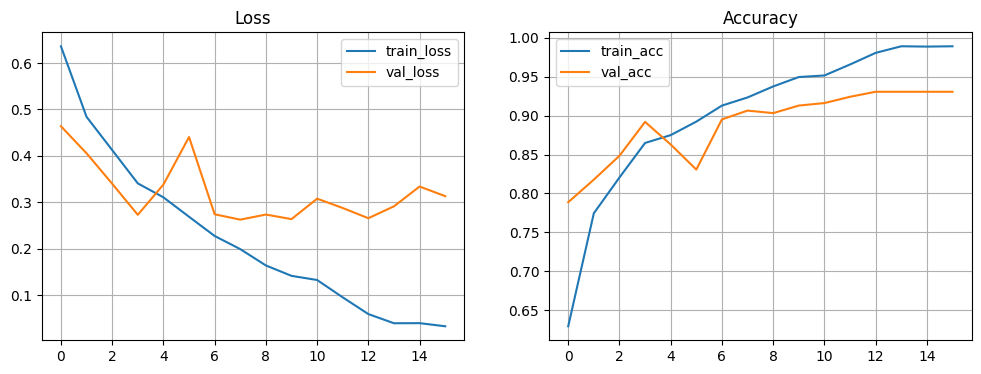

In [59]:
import matplotlib.pyplot as plt

def plot_history(h):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(h.history['loss'], label='train_loss')
    plt.plot(h.history['val_loss'], label='val_loss')
    plt.legend(); plt.title('Loss'); plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(h.history['accuracy'], label='train_acc')
    plt.plot(h.history['val_accuracy'], label='val_acc')
    plt.legend(); plt.title('Accuracy'); plt.grid(True)
    plt.show()

plot_history(history)

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Precision: 0.8987
Recall:    0.9161
F1 Score:  0.9073

Classification Report:

              precision    recall  f1-score   support

 Non-Violent       0.91      0.90      0.91       310
     Violent       0.90      0.92      0.91       310

    accuracy                           0.91       620
   macro avg       0.91      0.91      0.91       620
weighted avg       0.91      0.91      0.91       620



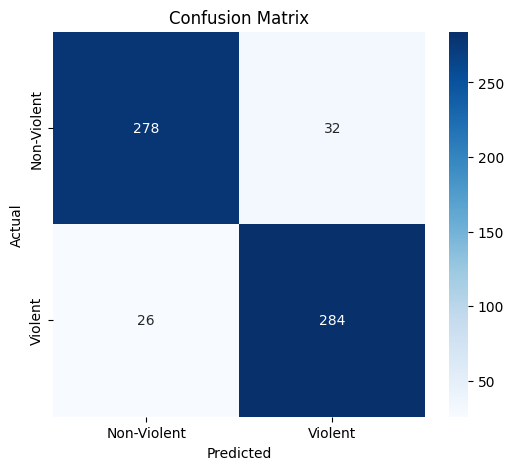

In [60]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

best_model = tf.keras.models.load_model(checkpoint_path)

y_pred_probs = best_model.predict(X_test, batch_size=8)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print("Precision: {:.4f}".format(precision))
print("Recall:    {:.4f}".format(recall))
print("F1 Score:  {:.4f}".format(f1))
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=["Non-Violent", "Violent"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-Violent","Violent"],
            yticklabels=["Non-Violent","Violent"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()


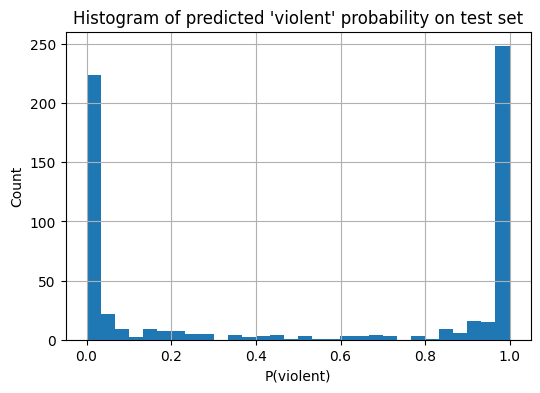

In [61]:
import matplotlib.pyplot as plt
violent_probs = y_pred_probs[:,1]
plt.figure(figsize=(6,4))
plt.hist(violent_probs, bins=30)
plt.title("Histogram of predicted 'violent' probability on test set")
plt.xlabel("P(violent)"); plt.ylabel("Count")
plt.grid(True)
plt.show()
